In [0]:
!git clone https://github.com/ikrets/keras-deeplab-v3-plus.git
!pip install tensorflow-gpu==2.0.0-alpha0

Cloning into 'keras-deeplab-v3-plus'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 255 (delta 42), reused 72 (delta 35), pack-reused 171
Receiving objects: 100% (255/255), 12.72 MiB | 14.88 MiB/s, done.
Resolving deltas: 100% (121/121), done.
    100% |████████████████████████████████| 332.1MB 63kB/s 
    100% |████████████████████████████████| 3.0MB 9.1MB/s 
    100% |████████████████████████████████| 419kB 13.8MB/s 
    100% |████████████████████████████████| 61kB 30.1MB/s 


In [0]:
import sys
import os
if 'keras-deeplab-v3-plus' not in sys.path:
    sys.path.append('keras-deeplab-v3-plus')

%load_ext autoreload
%autoreload 2

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from model import Deeplabv3

In [0]:
model_new = Deeplabv3(weights=None, 
                      OS=8, 
                      input_shape=(256, 640, 3), 
                      backbone='mobilenetv2', 
                      alpha=1.0, 
                      classes=2,
                      weight_decay=0.000001,
                      dropout=0)

model_new.load_weights('hopefully_right_starting_point.h5')

In [0]:
model_new.load_weights('val_miou_0.94_noreg_lossweiggts1_1_weights.h5')

In [0]:
from my_dataset import MyDataset

train_dataset = MyDataset(filename='train2.tfrecord',
                              batch_size=4,
                              shape=(256, 640),
                              num_readers=2,
                              num_classes=2,
                              is_training=True,
                              should_shuffle=True,
                              should_repeat=True,
                              should_augment=True).get()

val_dataset = MyDataset(filename='val2.tfrecord',
                       batch_size=4,
                       shape=(256, 640),
                       num_readers=2,
                       num_classes=2,
                       is_training=True,
                       should_shuffle=True,
                       should_repeat=True,
                       should_augment=False).get()

In [0]:
def make_loss(class_weights):
    num_classes = len(class_weights)
    def loss(labels, pred):
        weight_masks = []
        for i in range(num_classes):
            weight_masks.append(tf.cast(tf.equal(tf.argmax(labels, axis=-1), i),
                                        tf.float32) * class_weights[i])

        return tf.compat.v1.losses.softmax_cross_entropy(
            labels,
            pred,
            weights=tf.add_n(weight_masks))
    
    return loss

In [0]:
def miou_from_logits(true, pred):
    miou = tf.keras.metrics.MeanIoU(num_classes=2)
    return miou(tf.argmax(true, axis=-1), tf.argmax(tf.math.softmax(pred), axis=-1))

In [0]:
adam = tf.keras.optimizers.Adam(lr=0.001)
model_new.compile(optimizer=adam, loss=tf.compat.v1.losses.softmax_cross_entropy,
                  metrics=[miou_from_logits])

W0427 22:30:27.663069 139693396400000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/confusion_matrix.py:194: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0427 22:30:27.665877 139693396400000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/confusion_matrix.py:195: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [0]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='miou_from_logits',
                                                 factor=0.5,
                                                 patience=5,
                                                 min_delta=0.01,
                                                 mode='max',
                                                 verbose=True)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.001 / 2 ** (x / 80))

In [0]:
result = model_new.fit(train_dataset, epochs=300, steps_per_epoch=round(100/4),
             validation_data=val_dataset,
             validation_steps=round(25/4),
             callbacks=[lr_schedule])

Epoch 1/300
25/25 [==============================] - 51s 2s/step - loss: 0.2254 - miou_from_logits: 0.4799 - val_loss: 0.3360 - val_miou_from_logits: 0.5657
Epoch 2/300
25/25 [==============================] - 10s 409ms/step - loss: 0.0692 - miou_from_logits: 0.6051 - val_loss: 0.3968 - val_miou_from_logits: 0.6329
Epoch 3/300
25/25 [==============================] - 10s 405ms/step - loss: 0.0526 - miou_from_logits: 0.6543 - val_loss: 0.1665 - val_miou_from_logits: 0.6760
Epoch 4/300
25/25 [==============================] - 10s 407ms/step - loss: 0.0431 - miou_from_logits: 0.6926 - val_loss: 0.1343 - val_miou_from_logits: 0.7091
Epoch 5/300
25/25 [==============================] - 11s 440ms/step - loss: 0.0373 - miou_from_logits: 0.7205 - val_loss: 0.2400 - val_miou_from_logits: 0.7290
Epoch 6/300
25/25 [==============================] - 11s 420ms/step - loss: 0.0355 - miou_from_logits: 0.7370 - val_loss: 0.1454 - val_miou_from_logits: 0.7453
Epoch 7/300
25/25 [========================

In [0]:
model_new.evaluate(val_dataset, steps=100)

100/100 [==============================] - 12s 122ms/step - loss: 0.0354 - miou_from_logits: 0.9187


[0.03535337714478373, 0.91873956]

In [0]:
!zip -r eval_0.94.zip eval_out

In [0]:
!rm eval_out/*

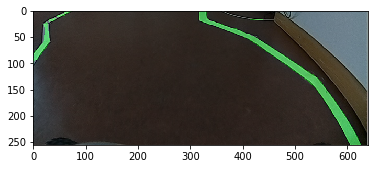

In [0]:
from glob import glob
from PIL import Image

alpha = 0.4
beta = 0
i = '2019-02-23-11-55-12_0/frame0098.jpg'
img = np.expand_dims(np.array(Image.open(i))[-256:, :, :], 0)
pp_img = img.astype(np.float32)
pp_img /= 127.5
pp_img -= 1

preds = np.expand_dims(
    np.argmax(model_new.predict(pp_img), axis=-1),
    axis=-1) * np.array([0, 255, 0])
r = alpha * preds + beta * np.array([10, 10, 10]) + (1 - alpha - beta) * img
plt.imshow(r.squeeze().astype(np.uint8))

In [0]:
import os
from PIL import Image

files = glob('2019-02-23-11-55-12_0/*.jpg')
alpha = 0.5
beta = 0.1

for f in files:
    img = np.expand_dims(Image.open(f), 0)
    img = img[:, -256:, :, :]
    pp_img = img.astype(np.float32)
    pp_img /= 127.5
    pp_img -= 1
    preds = model_new.predict(pp_img)
    preds = np.argmax(preds, axis=-1)
    preds = np.expand_dims(preds, axis=-1)
    
    res = alpha * preds * np.array([0, 255, 0])
    res += beta * np.array([10, 10, 10])
    res += (1 - alpha - beta) * img
    res = res.squeeze().astype(np.uint8)
    
    img = Image.fromarray(res)
    img.save(os.path.join('eval_out', os.path.split(f)[-1]))

W0426 11:27:41.627358 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


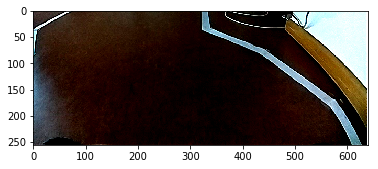

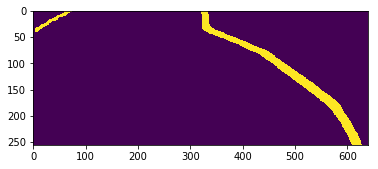

W0426 11:27:42.092932 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


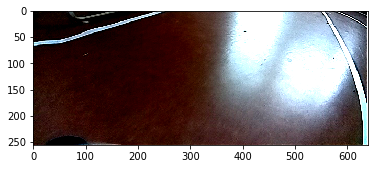

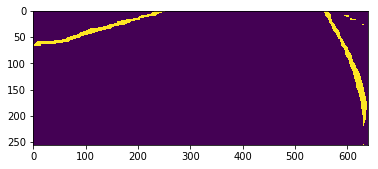

W0426 11:27:42.572163 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


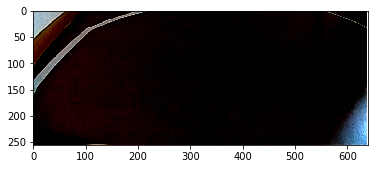

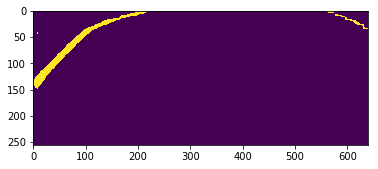

W0426 11:27:43.003478 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


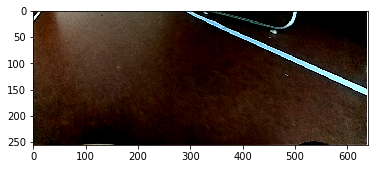

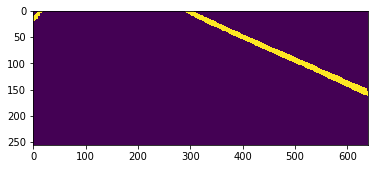

W0426 11:27:43.623029 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


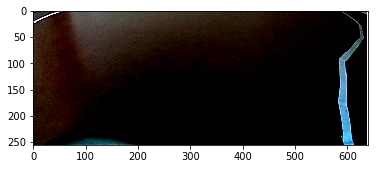

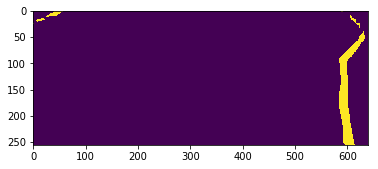

W0426 11:27:44.038704 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


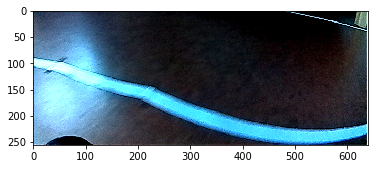

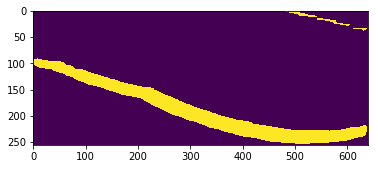

W0426 11:27:44.488832 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


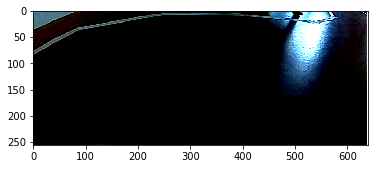

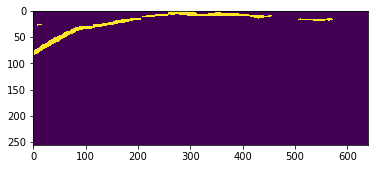

W0426 11:27:44.890561 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


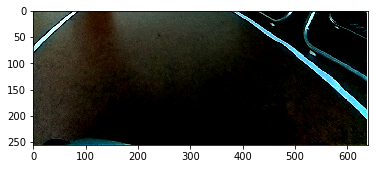

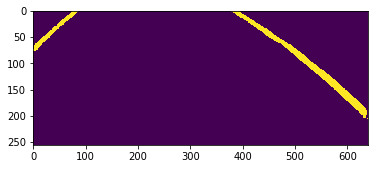

W0426 11:27:45.481929 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


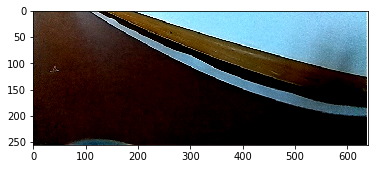

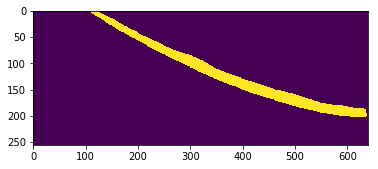

W0426 11:27:45.921483 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


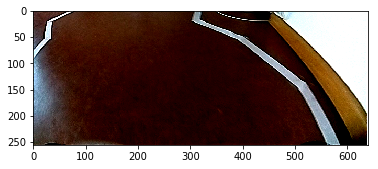

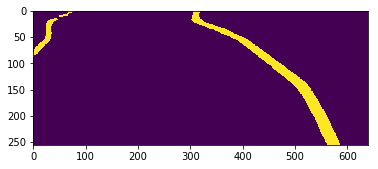

W0426 11:27:46.373235 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


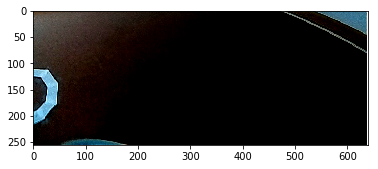

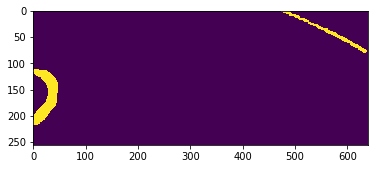

W0426 11:27:46.782189 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


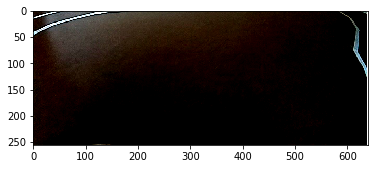

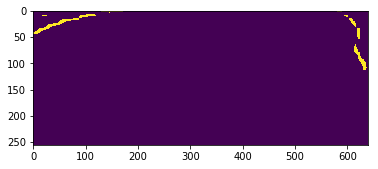

W0426 11:27:47.339497 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


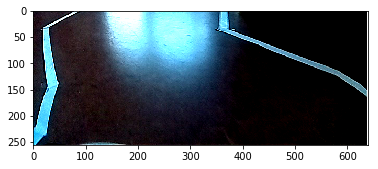

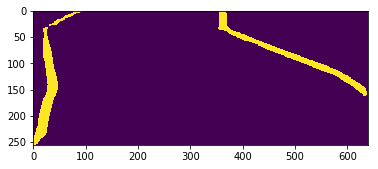

W0426 11:27:47.723813 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


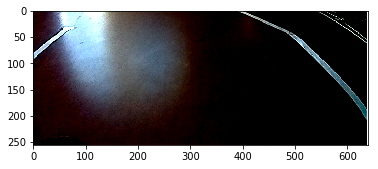

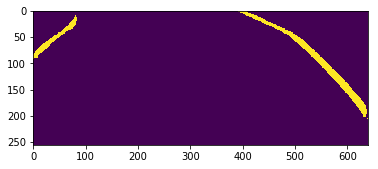

W0426 11:27:48.109914 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


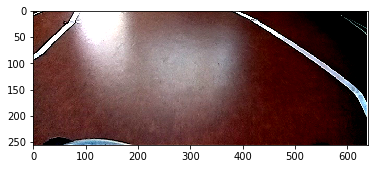

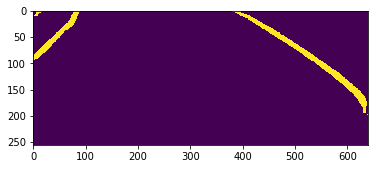

W0426 11:27:48.510401 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


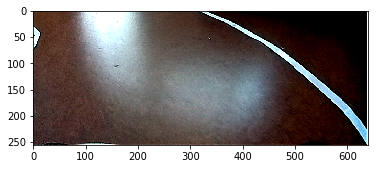

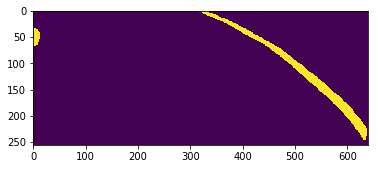

W0426 11:27:49.040690 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


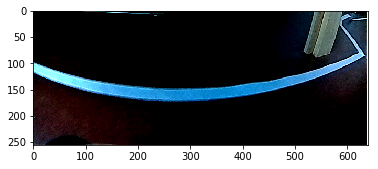

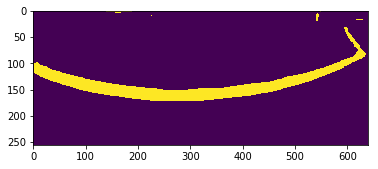

W0426 11:27:49.400784 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


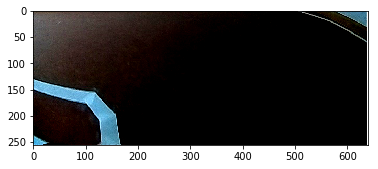

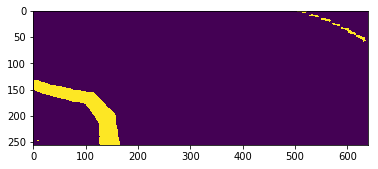

W0426 11:27:49.753161 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


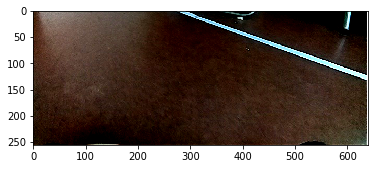

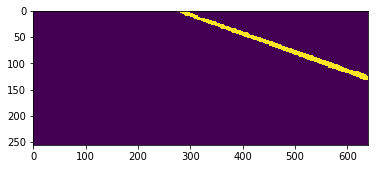

W0426 11:27:50.146545 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


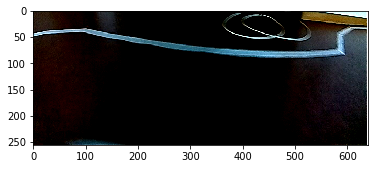

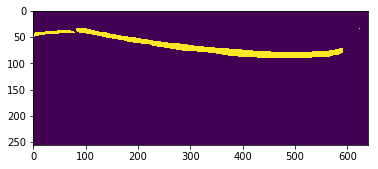

W0426 11:27:50.657225 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


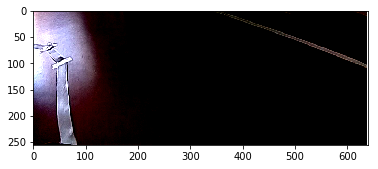

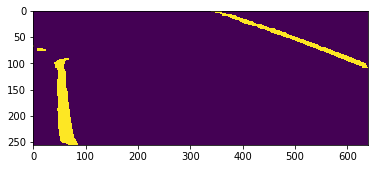

W0426 11:27:50.997494 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


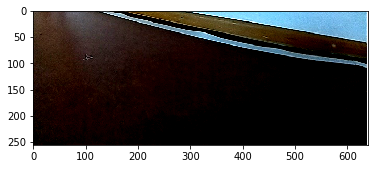

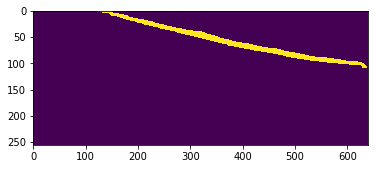

W0426 11:27:51.697419 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


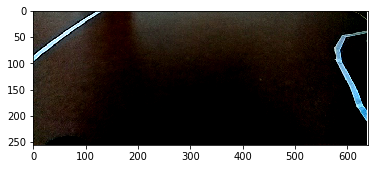

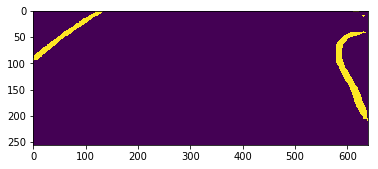

W0426 11:27:52.064826 140212181976960 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


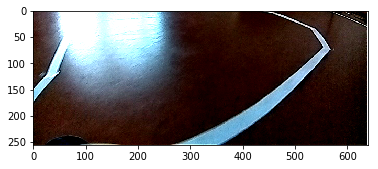

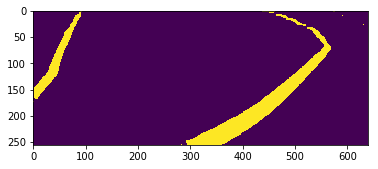

In [0]:
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
j = 0

for batch in val_dataset:
    j += 1
    preds = model_new.predict(batch[0])
    for i in range(len(preds)):
        plt.imshow((batch[0][i] + 0.5))
        plt.show()
        plt.imshow(np.argmax(softmax(preds[i]), axis=-1))
        plt.show()
    
    if j > 5:
        break

In [0]:
np.argmax(softmax(preds[0]), axis=-1).shape

(256, 640)

In [0]:
batch

AttributeError: ignored

In [0]:
predictions = model_new.predict(val_dataset, steps=25/4)

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [0]:
sample = np.array(Image.open('/home/ubuntu/dataset/images/home23_02_2019-02-23-11-55-12_0_frame0671.jpg'))
sample = (sample * 2.0 / 255.0) - 1.0

In [0]:
eval_dir = '/home/ubuntu/2019-02-23-11-55-12_0/'
evals = [os.path.join(eval_dir, f) for f in os.listdir(eval_dir)]

In [0]:
alpha = 0.4
eval_out_dir = '/home/ubuntu/eval_2019-02-23-11-55-12_0/'
if not os.path.exists(eval_out_dir):
    os.makedirs(eval_out_dir)

for e in list(os.listdir(eval_dir)):
    i = np.array(Image.open(os.path.join(eval_dir, e)))
    i = i[-256:, :, :]
    pred = model_new.predict(np.expand_dims(i * 2.0 / 255.0 - 1.0, axis=0))
    
    pred = np.argmax(np.squeeze(pred), axis=2)
    i[pred == 1] = alpha * np.array([0, 255, 0]) + (1 - alpha) * i[pred == 1] 
    
    i = Image.fromarray(i)
    i.save(os.path.join(eval_out_dir, e))

In [0]:
def plot_pred(pred):
    pred = np.squeeze(pred)
    pred = np.argmax(pred, axis=2)
    

    plt.imshow(pred)

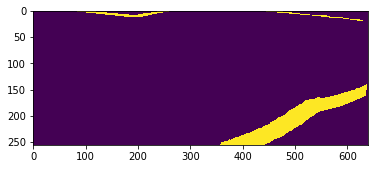

In [0]:
true = np.array(Image.open('/home/ubuntu/dataset/masks/home23_02_2019-02-23-11-55-12_0_frame0671.png'))
plt.imshow(true)